# ☕ Women's mood detector - BertAI Fine Tuning

This project uses a fine-tuned DistilBERT model to detect women's mood in short chat messages—because mostly men can’t even understand women, so why not let an AI try? Using the MTEB Emotion dataset, the model learns to recognize emotions such as joy, sadness, anger, fear, love, and surprise. The goal is to show that transformer models can spot emotional vibes in text and maybe help digital conversations make a little more sense… even when people don’t.

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

## Load Dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("mteb/emotion")
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 15956
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1988
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1986
    })
})
{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}


## Mapping label

In [83]:
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [2]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.5310, 0.8935, 0.2316],
        [0.6627, 0.0593, 0.2828],
        [0.8280, 0.6195, 0.6351],
        [0.4224, 0.1898, 0.5319],
        [0.2639, 0.3850, 0.6733]])


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing: tokenize kolom text

In [7]:
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=64,
    )

encoded = dataset.map(preprocess, batched=True)

# Pilih kolom yang dipakai model
cols = ["input_ids", "attention_mask", "label"]
encoded = encoded.rename_column("label", "labels")
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/15956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1988 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

## Training

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="bert-emotion",
    report_to="none",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy="epoch",
    logging_steps=100,
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

In [96]:
trainer.state.log_history

[{'loss': 1.38,
  'grad_norm': 2.7600371837615967,
  'learning_rate': 1.933867735470942e-05,
  'epoch': 0.10020040080160321,
  'step': 100},
 {'loss': 0.8813,
  'grad_norm': 9.915332794189453,
  'learning_rate': 1.8670674682698733e-05,
  'epoch': 0.20040080160320642,
  'step': 200},
 {'loss': 0.5699,
  'grad_norm': 6.669630527496338,
  'learning_rate': 1.8002672010688044e-05,
  'epoch': 0.30060120240480964,
  'step': 300},
 {'loss': 0.368,
  'grad_norm': 24.432762145996094,
  'learning_rate': 1.7334669338677356e-05,
  'epoch': 0.40080160320641284,
  'step': 400},
 {'loss': 0.3339,
  'grad_norm': 16.897785186767578,
  'learning_rate': 1.6666666666666667e-05,
  'epoch': 0.501002004008016,
  'step': 500},
 {'loss': 0.2823,
  'grad_norm': 3.0019500255584717,
  'learning_rate': 1.5998663994655982e-05,
  'epoch': 0.6012024048096193,
  'step': 600},
 {'loss': 0.2656,
  'grad_norm': 12.941789627075195,
  'learning_rate': 1.5330661322645294e-05,
  'epoch': 0.7014028056112225,
  'step': 700},
 {

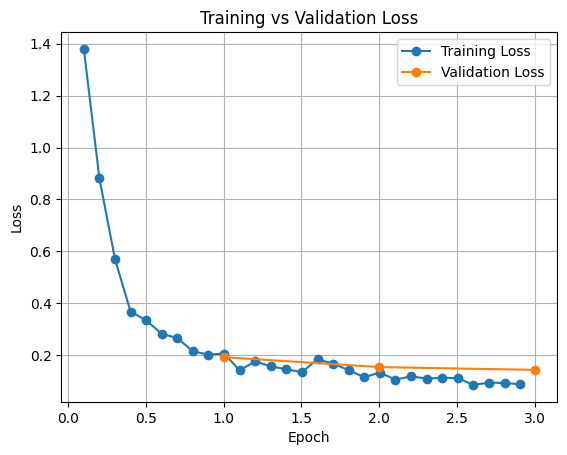

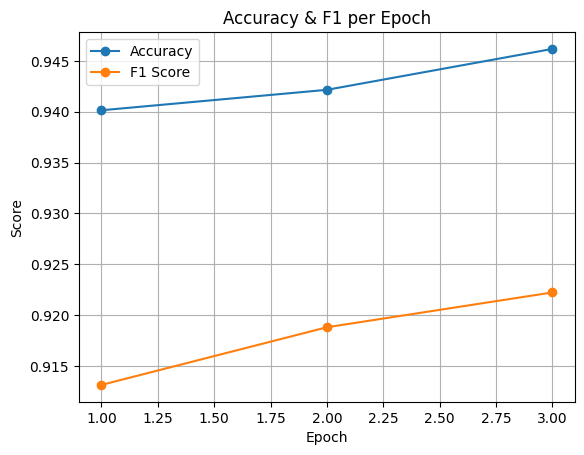

In [97]:
import matplotlib.pyplot as plt

# 1. Ambil semua log dari trainer
logs = trainer.state.log_history

# 2. Pisahkan log training dan validation per epoch
train_epochs = []
train_losses = []
val_epochs = []
val_losses = []
val_accs = []
val_f1s = []

for entry in logs:
    # log step training (ada 'loss' dan 'epoch', tapi bukan 'eval_loss')
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        train_epochs.append(entry["epoch"])
        train_losses.append(entry["loss"])
    # log eval (ada 'eval_loss')
    if "eval_loss" in entry:
        val_epochs.append(entry["epoch"])
        val_losses.append(entry["eval_loss"])
        if "eval_accuracy" in entry:
            val_accs.append(entry["eval_accuracy"])
        if "eval_f1" in entry:
            val_f1s.append(entry["eval_f1"])

# 3. Plot Training vs Validation Loss
plt.figure()
plt.plot(train_epochs, train_losses, marker='o', label="Training Loss")
plt.plot(val_epochs, val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# 4. Plot Accuracy & F1 (kalau ada)
if val_accs and val_f1s:
    plt.figure()
    plt.plot(val_epochs, val_accs, marker='o', label="Accuracy")
    plt.plot(val_epochs, val_f1s, marker='o', label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Accuracy & F1 per Epoch")
    plt.legend()
    plt.grid()
    plt.show()


## Cobain

In [86]:
import torch

def predict_mood(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )
    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits.softmax(dim=-1)[0]
        label_id = torch.argmax(probs).item()
    return id2label[label_id], float(probs[label_id])

print(predict_mood("im angry to you"))


('joy', 0.9980998635292053)


## Save model

In [68]:
# setelah trainer.train()
trainer.save_model("bert-emotion")  # ini nyimpen model + config

# kalau tokenizer-mu namanya tokenizer
tokenizer.save_pretrained("bert-emotion")

('bert-emotion\\tokenizer_config.json',
 'bert-emotion\\special_tokens_map.json',
 'bert-emotion\\vocab.txt',
 'bert-emotion\\added_tokens.json',
 'bert-emotion\\tokenizer.json')

In [69]:
import os

print(os.path.abspath("bert-emotion"))

D:\Projek\bert-chat-predict\bert-emotion


## Inference

In [94]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "bert-emotion" 

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

def predict_emotion(text: str):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0]

    pred_id = torch.argmax(probs).item()
    pred_label = id2label[pred_id]

    
    prob_dict = {
        id2label[i]: float(probs[i])
        for i in range(len(probs))
    }

    return pred_label, prob_dict

print(predict_emotion("i call u many times! you dont miss me?, are u cheating on me? where have u been?"))

('anger', {'sadness': 0.08650989085435867, 'joy': 0.0027059875428676605, 'love': 0.0008992949733510613, 'anger': 0.9053967595100403, 'fear': 0.004154128022491932, 'surprise': 0.0003339777758810669})
